# Binary Classification Using VGG16 architecture
- using pytorch

In [1]:
# package and module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
# ignore warning message
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data load
train_dir = os.path.join('./train_set')
test_dir = os.path.join('./test_set')

# image class path
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [4]:
# check the number of files
train_cats_file = os.listdir(train_cats_dir)
train_dogs_file = os.listdir(train_dogs_dir)
test_cats_file = os.listdir(test_cats_dir)
test_dogs_file = os.listdir(test_dogs_dir)
print('Total train cats images:', len(train_cats_file))
print('Total train dogs images:', len(train_dogs_file))
print('Total test cats images:', len(test_cats_file))
print('Total test dogs images:', len(test_dogs_file))

Total train cats images: 2389
Total train dogs images: 2535
Total valid cats images: 372
Total valid dogs images: 500
Total test cats images: 710
Total test dogs images: 750


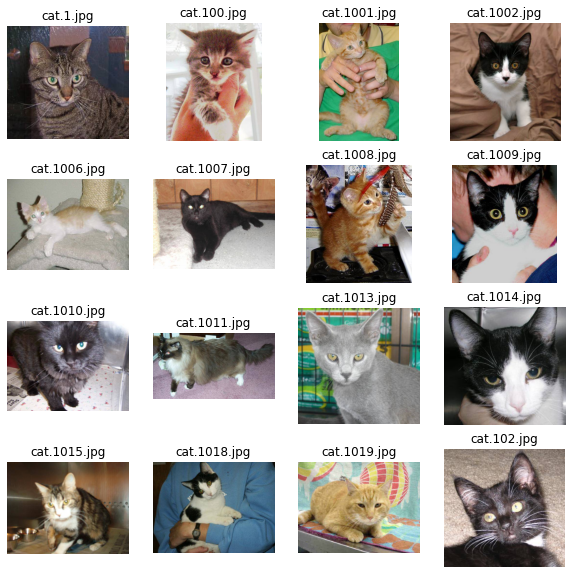

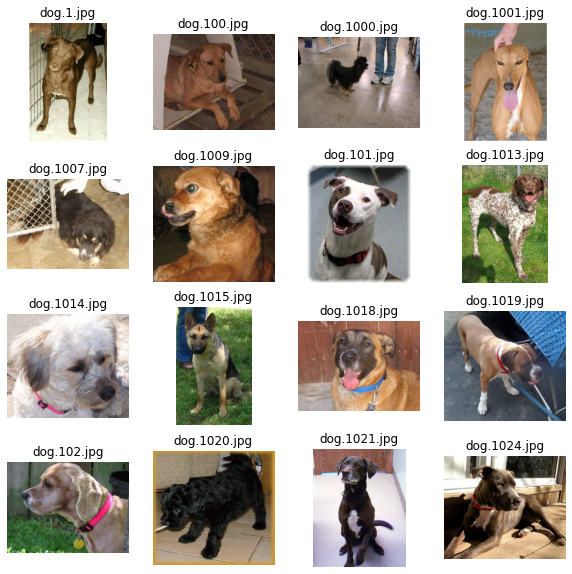

In [5]:
# show image
train_cat_image = [os.path.join(train_cats_dir, fname)
                   for fname in train_cats_file]
train_dog_image = [os.path.join(train_dogs_dir, fname)
                   for fname in train_dogs_file]

def show_image(nrows, ncols, data_path):
    plt.figure(figsize=(10,10))
    for i in range(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(Image.open(data_path[i]))
        plt.title(data_path[i].split('\\')[-1])
        plt.axis('off')
    plt.show()

nrows, ncols = 4, 4
show_image(nrows, ncols, train_cat_image)
show_image(nrows, ncols, train_dog_image)

In [21]:
# load image folder
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
train_images = ImageFolder(train_dir, transform=transform, target_transform=None)

In [22]:
# hyperparameter setting
batch_size = 32
learning_rate = 1e-4
num_epoch = 100

In [23]:
# load data
train_loader = DataLoader(train_images, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0, 
                          drop_last=True)

In [34]:
# load vgg16
base_model = models.vgg16(pretrained=False)

# create fully connected model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.feature = nn.Sequential(*list(base_model.children())[0:-1][0])
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc_layer = nn.Sequential(
            nn.Linear(512,100), nn.ReLU(),
            nn.Linear(100,2)
        )
    def forward(self, x):
        out = self.feature(x)
        out = self.gap(out)
        out = torch.squeeze(out)
        out = self.fc_layer(out)
        return out

In [40]:
# setting "gpu" device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
new_model = CNN().to(device)

for params in new_model.feature.parameters():
    params.require_grad = False
for params in new_model.fc_layer.parameters():
    params.requires_grad = True
    
summary(new_model, (3,224,224))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-

In [41]:
# set loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate)

In [42]:
# model training
loss_list = []

for i in tqdm(range(num_epoch)):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = new_model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
    print(loss)
    loss_list.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.6496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7883, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4780, device='cuda:0', grad_fn=

In [44]:
# load test data
test_images = ImageFolder(test_dir, transform=transform, target_transform=None)
test_loader = DataLoader(test_images,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0,
                         drop_last=True)

In [45]:
# model predict
correct, total = 0, 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        output = new_model.forward(x)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index==y).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 87.77777862548828
